In [1]:
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
import os
import pickle

# Scope defines the level of access you need
SCOPES = ['https://www.googleapis.com/auth/drive']

creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

service = build('drive', 'v3', credentials=creds)

In [2]:
!nvidia-smi

Thu Mar 28 13:58:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX330         WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0              N/A / ERR! |      0MiB /  2048MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
def list_files_in_folder(folder_id):
    query = f"'{folder_id}' in parents"
    results = service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])
    if not items:
        print('No files found.')
    else:
        print('Files:')
        for item in items:
            print(u'{0} ({1})'.format(item['name'], item['id']))

# Replace YOUR_FOLDER_ID with your actual folder ID
list_files_in_folder('1Ap_ZH6vhoRpRxzu1eTdrpithBZKmBGE9')

Files:
DataSets (1R5KKeNFyJGT1qUn-r-gSHAhrCS1m_t66)


In [4]:
def find_file_id_by_path(service, path, parent_id='root'):
    """
    Find a file ID by its path.
    """
    parts = path.strip('/').split('/')
    file_id = parent_id
    for part in parts:
        # Search for the file by name and parent ID
        query = f"'{file_id}' in parents and name = '{part}' and trashed = false"
        response = service.files().list(q=query, spaces='drive', fields='files(id, name)').execute()
        files = response.get('files', [])
        if not files:
            print(f"No file found for part '{part}'.")
            return None
        file_id = files[0]['id']
    return file_id


In [5]:
def download_file_by_id(service, file_id):
    """
    Download a file's content by its file ID.
    """
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    fh.seek(0)
    return fh.read()


In [6]:
import io
from googleapiclient.http import MediaIoBaseDownload

# Example usage
path = '/MyDrive/PFA_codes/DataSets/CICIDS2017/ProcessedDataset'  # Adjust the path to your file
file_id = find_file_id_by_path(service, path)
if file_id:
    content = download_file_by_id(service, file_id)
    print(content.decode('utf-8'))  # Assuming the file content is text


No file found for part 'MyDrive'.


In [7]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

def download_file(service, file_id):
    """
    Download a file from Google Drive specified by file_id.
    """
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        _, done = downloader.next_chunk()

    fh.seek(0)
    return fh.getvalue()


In [8]:
import pandas as pd

def download_file_as_dataframe(service, file_id):
    file_content = download_file(service, file_id)
    return pd.read_csv(io.BytesIO(file_content))


In [9]:
import os
import logging

import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)

    # Split features and labels
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # Scale the features between 0 ~ 1
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    print('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    print("\n{}".format(classification_report(y_test, y_pred)))


In [11]:
def create_cnn_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(9, 9, 1))
    x = keras.layers.Conv2D(120, 2, activation='relu', padding="same")(inputs)
    x = keras.layers.Conv2D(60, 3, activation='relu', padding="same")(x)
    x = keras.layers.Conv2D(30, 4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

In [12]:
# Create model
model = create_cnn_model()
logging.info(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 120)         600       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 60)          64860     
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 30)          28830     
                                                                 
 flatten (Flatten)           (None, 2430)              0         
                                                                 
 dense (Dense)               (None, 15)                36465     
                                                                 
Total params: 130,755
Trainable params: 130,755
Non-trainable p

14:20:11 INFO None


In [13]:
#plot_model(model, show_shapes=True)

In [14]:
# Replace 'YOUR_FILE_ID' with the actual file ID
file_id = '1-1FgQNeXFB-cdhVZ_0uvcoAXPLwxJ-U_'
df = download_file_as_dataframe(service, file_id)
print(df.head())


   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             465.0          138.0                3.0                     0.0   
1              80.0        14509.0                2.0                     0.0   
2              80.0    117366735.0               20.0                    16.0   
3           39676.0            4.0                2.0                     0.0   
4              53.0        60732.0                1.0                     1.0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         49.0                          0.0   
1                         12.0                          0.0   
2                       1317.0                       2388.0   
3                          0.0                          0.0   
4                         43.0                        101.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                   37.0                    6.0            

In [15]:
from googleapiclient.http import MediaFileUpload

def upload_file_to_drive(service, file_name, folder_id, mime_type='application/octet-stream'):
    file_metadata = {'name': file_name, 'parents': [folder_id]}
    media = MediaFileUpload(file_name, mimetype=mime_type)
    file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    print('File ID: %s' % file.get('id'))


In [16]:
from tensorflow.keras.callbacks import Callback
import os

class DriveCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1, drive_service=None, folder_id=None):
        super(DriveCheckpoint, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.drive_service = drive_service
        self.folder_id = folder_id

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('ModelCheckpoint mode %s is unknown, fallback to auto mode.' % (mode), RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f, saving model to %s' % (epoch + 1, self.monitor, self.best, current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model.save_weights(filepath, overwrite=True)
                        else:
                            self.model.save(filepath, overwrite=True)
                        upload_file_to_drive(self.drive_service, filepath, self.folder_id)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' % (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)
                upload_file_to_drive(self.drive_service, filepath, self.folder_id)


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Assuming your model is defined as `model`
# Replace these with your actual folder ID on Google Drive and the service object
drive_service = service  # The Google Drive service object created during authentication
drive_folder_id = '1mIKKTtCuPqWAjmoBAHeCfdnZBAp1QiKj'

# Define the path for the checkpoint files
# Note: This path is for saving locally before uploading
checkpoint_path = "C:/Users/benzaied saif/Desktop/checkpoints" 

# Set up your other callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Instantiate your custom DriveCheckpoint callback
drive_checkpoint = DriveCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    drive_service=drive_service,
    folder_id=drive_folder_id
)

# Add callbacks to the callbacks list
callbacks_list = [early_stopping, drive_checkpoint]


In [18]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [19]:
# Training
print("*** TRAINING START ***")
history = model.fit(X, Y, validation_split=0.1, epochs=125, batch_size=1024, verbose=True)

*** TRAINING START ***
Epoch 1/125
4614/4614 [==============================] - 3394s 686ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.0279 - val_sparse_categorical_accuracy: 0.9899
Epoch 2/125
4614/4614 [==============================] - 3084s 669ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.0129 - val_sparse_categorical_accuracy: 0.9977
Epoch 3/125
4614/4614 [==============================] - 3102s 672ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0079 - val_sparse_categorical_accuracy: 0.9983
Epoch 4/125
4614/4614 [==============================] - 3027s 656ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0065 - val_sparse_categorical_accuracy: 0.9982
Epoch 5/125
4614/4614 [==============================] - 3024s 655ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.0049 - val_sparse_categorical_accuracy: 0.9987
Epoch 6/125
4614/4614 [==============

4614/4614 [==============================] - 3025s 656ms/step - loss: 0.0030 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0036 - val_sparse_categorical_accuracy: 0.9991
Epoch 45/125
4614/4614 [==============================] - 2994s 649ms/step - loss: 0.0030 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0034 - val_sparse_categorical_accuracy: 0.9991
Epoch 46/125
4614/4614 [==============================] - 2966s 643ms/step - loss: 0.0030 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0035 - val_sparse_categorical_accuracy: 0.9991
Epoch 47/125
4614/4614 [==============================] - 2997s 649ms/step - loss: 0.0030 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0038 - val_sparse_categorical_accuracy: 0.9991
Epoch 48/125
4614/4614 [==============================] - 2981s 646ms/step - loss: 0.0029 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0036 - val_sparse_categorical_accuracy: 0.9991
Epoch 49/125
4614/4614 [==============================] - 2976s 645m

4614/4614 [==============================] - 3048s 661ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0034 - val_sparse_categorical_accuracy: 0.9991
Epoch 88/125
4614/4614 [==============================] - 3146s 682ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0037 - val_sparse_categorical_accuracy: 0.9990
Epoch 89/125
4614/4614 [==============================] - 3029s 657ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0038 - val_sparse_categorical_accuracy: 0.9991
Epoch 90/125
4614/4614 [==============================] - 3074s 666ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0036 - val_sparse_categorical_accuracy: 0.9992
Epoch 91/125
4614/4614 [==============================] - 3126s 678ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0034 - val_sparse_categorical_accuracy: 0.9991
Epoch 92/125
4614/4614 [==============================] - 3289s 713m

In [20]:
print("*** TRAINING FINISH ***")
del X, Y

*** TRAINING FINISH ***


In [21]:
def upload_model_to_drive(service, file_name, folder_id, mime_type='application/octet-stream'):
    file_metadata = {'name': os.path.basename(file_name), 'parents': [folder_id]}
    media = MediaFileUpload(file_name, mimetype=mime_type)
    file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    print('Uploaded File ID: %s' % file.get('id'))


Uploaded File ID: 1ORvWu4Skg0cWcpS-JBTw_ZTevfiTjzv-


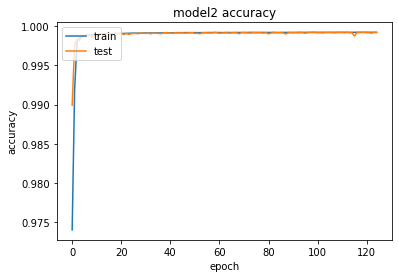

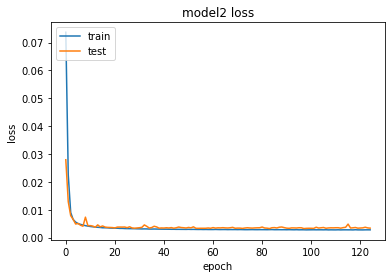

In [30]:
# Save the full model
#model.save(os.path.join(r"C:\Users\benzaied saif\Desktop\model\CNN", "cnn_full_model.h5"))

upload_model_to_drive(service, os.path.join(r"C:\Users\benzaied saif\Desktop\model\CNN", "cnn_full_model.h5"), '1mIKKTtCuPqWAjmoBAHeCfdnZBAp1QiKj')

plot_history(history)

In [31]:
file_id = '1ZLpmbcBSIfyKlZGHO2tuVk3xGK8J_cBy'
df = download_file_as_dataframe(service, file_id)
print(df.head())
print("Class distribution\n{}".format(df.Label.value_counts()))

   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              80.0      5237610.0                4.0                     4.0   
1              53.0       333394.0                1.0                     1.0   
2             443.0       103990.0               10.0                     5.0   
3              53.0        23559.0                1.0                     1.0   
4              80.0     97934363.0               18.0                    16.0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                       1178.0                        354.0   
1                         46.0                         62.0   
2                        966.0                       1631.0   
3                         43.0                         59.0   
4                        868.0                       3925.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                 1178.0                    0.0            

In [32]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [33]:
evaluation(model, X, Y)
del X, Y

Evaluation:
Loss: 0.004239625763148069
Accuracy : 0.9989125728607178


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1086738
         1.0       0.89      0.70      0.79       786
         2.0       1.00      0.99      1.00     51212
         3.0       0.99      1.00      0.99      4118
         4.0       1.00      1.00      1.00     92430
         5.0       0.98      0.98      0.98      2200
         6.0       0.99      1.00      0.99      2318
         7.0       1.00      1.00      1.00      4763
         8.0       1.00      1.00      1.00         4
         9.0       1.00      0.93      0.96        14
        10.0       0.99      1.00      1.00     63572
        11.0       1.00      1.00      1.00      3275
        12.0       0.71      0.95      0.81       602
        13.0       0.78      0.88      0.82         8
        14.0       0.42      0.10      0.16       260

    accuracy                           1.00   1312300
   macro 

In [34]:
print("*** END ***")

*** END ***
